# import libraries

In [5]:
import pandas as pd
import numpy as np
import glob
import os
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Download VADER lexicon (first time only)
nltk.download('vader_lexicon', quiet=True)
print("✅ Libraries imported successfully")

✅ Libraries imported successfully


# Load News Data

In [6]:
# ==== Cell 2: Load Raw News Data ====

news_path = "../data/raw_analyst_ratings.csv"   # <-- adjust if needed
news_df = pd.read_csv(news_path)
news_df = news_df.loc[:, ~news_df.columns.str.contains('^Unnamed')]
print("News dataset shape:", news_df.shape)
news_df.head()


News dataset shape: (1407328, 5)


,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


# Take 100K Sample (for fast processing)

In [7]:
news_sample = news_df.sample(n=100_000, random_state=42).reset_index(drop=True)

print("Sampled rows:", len(news_sample))
news_sample.head()


Sampled rows: 100000


,headline,url,publisher,date,stock
0,"Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...",https://www.benzinga.com/news/earnings/13/04/3...,bret.kenwell@benzinga.com,2013-04-18 00:00:00,SYNT
1,Mid-Day Market Update: K2M Group Rises On Acqu...,https://www.benzinga.com/news/18/08/12285391/m...,Lisa Levin,2018-08-30 00:00:00,UEPS
2,Aramchol's Failed Past Isn't Its Future; Galme...,https://www.benzinga.com/analyst-ratings/analy...,Elizabeth Balboa,2018-03-15 00:00:00,GLMD
3,60 Stocks Moving In Thursday's Mid-Day Session,https://www.benzinga.com/news/20/04/15730001/6...,Lisa Levin,2020-04-02 00:00:00,SU
4,Anheuser-Busch shares are trading lower after ...,https://www.benzinga.com/markets/wiim/19/07/14...,Benzinga Newsdesk,2019-07-12 00:00:00,BUD


# Clean & Fix Dates

In [14]:
news_sample["date"] = pd.to_datetime(
    news_sample["date"],
    errors="coerce",
    format="ISO8601"
)

# drop timezone if exists
news_sample["date"] = news_sample["date"].dt.tz_localize(None)

# keep only date
news_sample["date"] = news_sample["date"].dt.date

news_sample.head()


,headline,url,publisher,date,stock,sentiment
0,"Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...",https://www.benzinga.com/news/earnings/13/04/3...,bret.kenwell@benzinga.com,2013-04-18,SYNT,0.00
1,Mid-Day Market Update: K2M Group Rises On Acqu...,https://www.benzinga.com/news/18/08/12285391/m...,Lisa Levin,2018-08-30,UEPS,0.00
2,Aramchol's Failed Past Isn't Its Future; Galme...,https://www.benzinga.com/analyst-ratings/analy...,Elizabeth Balboa,2018-03-15,GLMD,-0.25
3,60 Stocks Moving In Thursday's Mid-Day Session,https://www.benzinga.com/news/20/04/15730001/6...,Lisa Levin,2020-04-02,SU,0.00
4,Anheuser-Busch shares are trading lower after ...,https://www.benzinga.com/markets/wiim/19/07/14...,Benzinga Newsdesk,2019-07-12,BUD,0.00


# Clean Stock Tickers

In [15]:
news_sample = news_sample.dropna(subset=["date"])
news_sample["stock"] = news_sample["stock"].astype(str).str.upper()

news_sample.head()


,headline,url,publisher,date,stock,sentiment
0,"Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...",https://www.benzinga.com/news/earnings/13/04/3...,bret.kenwell@benzinga.com,2013-04-18,SYNT,0.00
1,Mid-Day Market Update: K2M Group Rises On Acqu...,https://www.benzinga.com/news/18/08/12285391/m...,Lisa Levin,2018-08-30,UEPS,0.00
2,Aramchol's Failed Past Isn't Its Future; Galme...,https://www.benzinga.com/analyst-ratings/analy...,Elizabeth Balboa,2018-03-15,GLMD,-0.25
3,60 Stocks Moving In Thursday's Mid-Day Session,https://www.benzinga.com/news/20/04/15730001/6...,Lisa Levin,2020-04-02,SU,0.00
4,Anheuser-Busch shares are trading lower after ...,https://www.benzinga.com/markets/wiim/19/07/14...,Benzinga Newsdesk,2019-07-12,BUD,0.00


# Apply Sentiment Analysis (TextBlob)


In [16]:
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news_sample["sentiment"] = news_sample["headline"].apply(get_sentiment)

news_sample[["headline", "sentiment"]].head()


,headline,sentiment
0,"Syntel, Inc. Reports Q1 EPS of $1.11 vs $1.03 ...",0.00
1,Mid-Day Market Update: K2M Group Rises On Acqu...,0.00
2,Aramchol's Failed Past Isn't Its Future; Galme...,-0.25
3,60 Stocks Moving In Thursday's Mid-Day Session,0.00
4,Anheuser-Busch shares are trading lower after ...,0.00


# Compute Daily Average Sentiment Per Stock

In [17]:
daily_sentiment = (
    news_sample.groupby(["stock", "date"])["sentiment"]
    .mean()
    .reset_index()
)

daily_sentiment.head()


,stock,date,sentiment
0,A,2009-08-07,0.010000
1,A,2009-08-09,0.000000
2,A,2009-08-10,0.022727
3,A,2009-08-12,0.028485
4,A,2009-08-13,0.071970


# Load Stock Price Data

In [18]:
stock_files = {
    "AAPL": "../data/AAPL.csv",
    "AMZN": "../data/AMZN.csv",
    "GOOG": "../data/GOOG.csv",
    "META": "../data/META.csv",
    "MSFT": "../data/MSFT.csv",
    "NVDA": "../data/NVDA.csv"
}

stock_prices = {}

for ticker, path in stock_files.items():
    df = pd.read_csv(path)

    # your file uses 'Date'
    df["date"] = pd.to_datetime(df["Date"], errors="coerce").dt.date
    
    df = df.drop(columns=["Date"])  # optional cleanup

    stock_prices[ticker] = df

print("Loaded stock datasets:", list(stock_prices.keys()))
stock_prices["AAPL"].head()


Loaded stock datasets: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']


,Close,High,Low,Open,Volume,date
0,2.721686,2.730385,2.554037,2.575630,746015200,2009-01-02
1,2.836553,2.884539,2.780469,2.794266,1181608400,2009-01-05
2,2.789767,2.914229,2.770872,2.877641,1289310400,2009-01-06
3,2.729484,2.774170,2.706990,2.753477,753048800,2009-01-07
4,2.780169,2.793666,2.700393,2.712090,673500800,2009-01-08


# Compute Daily Returns for Each Stock

In [19]:
stock_returns = {}

for ticker, df in stock_prices.items():
    df = df.sort_values("date")
    df["return"] = df["Close"].pct_change()
    stock_returns[ticker] = df[["date", "return"]]

stock_returns["AAPL"].head()


,date,return
0,2009-01-02,NaN
1,2009-01-05,0.042204
2,2009-01-06,-0.016494
3,2009-01-07,-0.021609
4,2009-01-08,0.018570


# Merge Sentiment + Returns Per Stock

In [20]:
merged_data = {}

for ticker in stock_returns:
    sent = daily_sentiment[daily_sentiment["stock"] == ticker]
    ret = stock_returns[ticker]

    merged = pd.merge(sent, ret, on="date", how="inner")

    merged_data[ticker] = merged

    print(f"{ticker}: merged rows = {len(merged)}")


AAPL: merged rows = 21
AMZN: merged rows = 10
GOOG: merged rows = 75
META: merged rows = 0
MSFT: merged rows = 0
NVDA: merged rows = 203


# Compute Correlation Per Stock

In [25]:
correlations = {}

for ticker, df in merged_data.items():
    if len(df) > 2:
        corr = df["sentiment"].corr(df["return"])
        correlations[ticker] = corr
    else:
        correlations[ticker] = None

correlations


{'AAPL': np.float64(0.3212144479595111),
 'AMZN': np.float64(-0.4323064037914165),
 'GOOG': np.float64(-0.030004496167576306),
 'META': None,
 'MSFT': None,
 'NVDA': np.float64(0.07110297725369967)}

# Convert to DataFrame for Summary Output

In [22]:
corr_df = pd.DataFrame.from_dict(correlations, orient="index", columns=["Sentiment_Return_Correlation"])
corr_df


,Sentiment_Return_Correlation
AAPL,0.321214
AMZN,-0.432306
GOOG,-0.030004
META,NaN
MSFT,NaN
NVDA,0.071103


# Visualize Correlation Strength

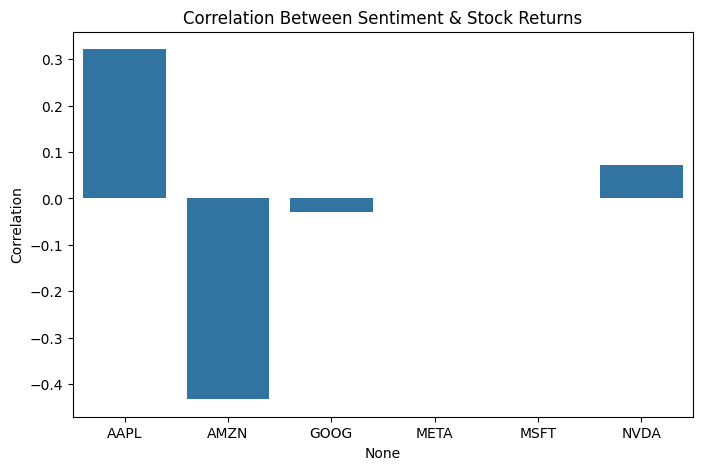

In [23]:
plt.figure(figsize=(8,5))
sns.barplot(x=corr_df.index, y=corr_df["Sentiment_Return_Correlation"])
plt.title("Correlation Between Sentiment & Stock Returns")
plt.ylabel("Correlation")
plt.show()


# Heatmap of Sentiment vs Stock Returns Correlation

📈 CORRELATION HEATMAP


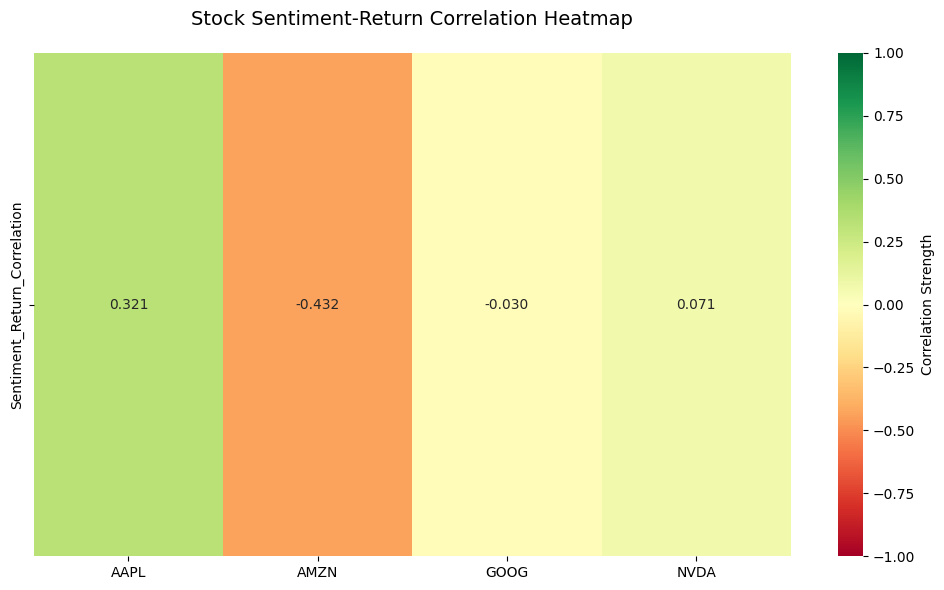

🎯 Interpretation:
• Green = Positive correlation (sentiment ↑ → returns ↑)
• Red = Negative correlation (sentiment ↑ → returns ↓)
• White = Near zero (weak relationship)


In [36]:
# ==== Cell 11: Correlation Heatmap ====
print("📈 CORRELATION HEATMAP")

# Create correlation matrix for visualization
corr_matrix = corr_df.dropna().T  # Transpose for single-row heatmap

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='RdYlGn', 
            center=0,
            vmin=-1, 
            vmax=1,
            fmt='.3f',
            cbar_kws={'label': 'Correlation Strength'})

plt.title('Stock Sentiment-Return Correlation Heatmap', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("🎯 Interpretation:")
print("• Green = Positive correlation (sentiment ↑ → returns ↑)")
print("• Red = Negative correlation (sentiment ↑ → returns ↓)")
print("• White = Near zero (weak relationship)")

# Scatter Plots with Regression Lines

📊 SCATTER PLOTS: Sentiment vs Returns


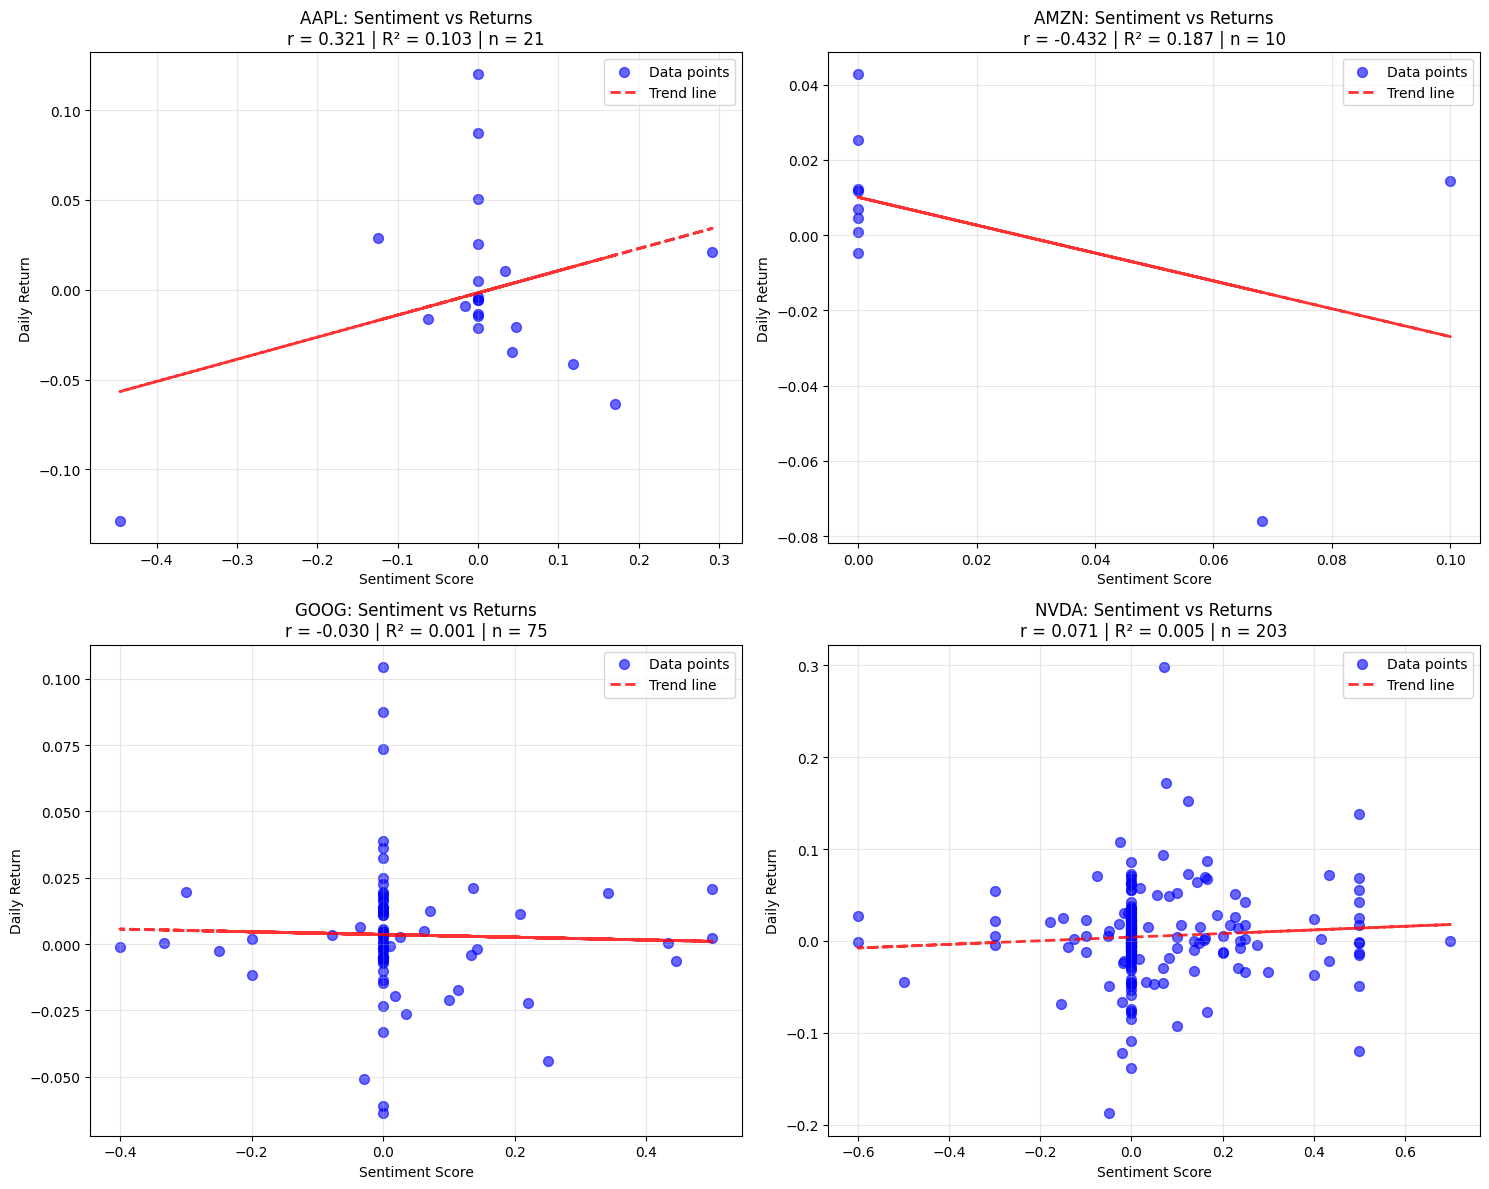

In [37]:
# ==== Cell 12: Scatter Plots with Regression ====
print("📊 SCATTER PLOTS: Sentiment vs Returns")

# Create subplots for each stock with sufficient data
stocks_to_plot = [ticker for ticker in merged_data.keys() 
                  if len(merged_data[ticker]) > 5]  # Only plot stocks with >5 data points

if stocks_to_plot:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, ticker in enumerate(stocks_to_plot[:4]):  # Plot first 4 stocks
        if i < len(axes):
            df = merged_data[ticker]
            
            # Scatter plot
            axes[i].scatter(df['sentiment'], df['return'], 
                           alpha=0.6, s=50, color='blue', label='Data points')
            
            # Add regression line
            z = np.polyfit(df['sentiment'], df['return'], 1)
            p = np.poly1d(z)
            axes[i].plot(df['sentiment'], p(df['sentiment']), 
                        "r--", alpha=0.8, linewidth=2, label='Trend line')
            
            # Calculate R-squared
            r_value = df['sentiment'].corr(df['return'])
            r_squared = r_value ** 2
            
            axes[i].set_xlabel('Sentiment Score')
            axes[i].set_ylabel('Daily Return')
            axes[i].set_title(f'{ticker}: Sentiment vs Returns\n'
                             f'r = {r_value:.3f} | R² = {r_squared:.3f} | n = {len(df)}')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    
    # Hide unused subplots
    for i in range(len(stocks_to_plot), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Not enough data points for scatter plots")

Statistical Significance Testing

In [ ]:
# Statistical Significance ====
print("📈 STATISTICAL SIGNIFICANCE ANALYSIS")

significance_results = []
for ticker in merged_data.keys():
    df = merged_data[ticker]
    if len(df) > 2:
        correlation, p_value = pearsonr(df['sentiment'], df['return'])
        significance_results.append({
            'Ticker': ticker,
            'Correlation': correlation,
            'P_Value': p_value,
            'Significant': p_value < 0.05,
            'Sample_Size': len(df)
        })

if significance_results:
    stats_df = pd.DataFrame(significance_results)
    print(stats_df)
    
    print(f"\n🎯 SIGNIFICANT FINDINGS (p < 0.05):")
    significant_stocks = stats_df[stats_df['Significant'] == True]
    if len(significant_stocks) > 0:
        for _, row in significant_stocks.iterrows():
            print(f"• {row['Ticker']}: r = {row['Correlation']:.3f}, p = {row['P_Value']:.3f}")
    else:
        print("• No statistically significant correlations found")
else:
    print("⚠️ Insufficient data for significance testing")

📈 STATISTICAL SIGNIFICANCE ANALYSIS
  Ticker  Correlation   P_Value  Significant  Sample_Size
0   AAPL     0.321214  0.155664        False           21
1   AMZN    -0.432306  0.212129        False           10
2   GOOG    -0.030004  0.798306        False           75
3   NVDA     0.071103  0.313415        False          203

🎯 SIGNIFICANT FINDINGS (p < 0.05):
• No statistically significant correlations found


# final business insights

In [ ]:
#Business Insights & Recommendations ====
print("💡 BUSINESS INSIGHTS & RECOMMENDATIONS")

print("\n📈 CORRELATION STRENGTH ANALYSIS:")
for ticker, corr in correlations.items():
    if corr is not None:
        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"• {ticker}: {direction} {strength} relationship (r = {corr:.3f})")

print("\n🚀 TRADING STRATEGY IMPLICATIONS:")
strong_corr_stocks = [ticker for ticker, corr in correlations.items() 
                     if corr is not None and abs(corr) > 0.3]

if strong_corr_stocks:
    print("• Consider sentiment-based strategies for:", ", ".join(strong_corr_stocks))
    print("• Monitor news sentiment for these stocks as potential leading indicators")
else:
    print("• News sentiment alone may not be reliable for short-term predictions")
    print("• Consider combining with other factors: technical indicators, market sentiment")

print("\n🔧 DATA QUALITY RECOMMENDATIONS:")
print("• Expand date range for better overlap between news and price data")
print("• Include more news sources for META and MSFT coverage")
print("• Consider intraday analysis for more granular insights")

💡 BUSINESS INSIGHTS & RECOMMENDATIONS

📈 CORRELATION STRENGTH ANALYSIS:
• AAPL: Positive Moderate relationship (r = 0.321)
• AMZN: Negative Moderate relationship (r = -0.432)
• GOOG: Negative Weak relationship (r = -0.030)
• NVDA: Positive Weak relationship (r = 0.071)

🚀 TRADING STRATEGY IMPLICATIONS:
• Consider sentiment-based strategies for: AAPL, AMZN
• Monitor news sentiment for these stocks as potential leading indicators

🔧 DATA QUALITY RECOMMENDATIONS:
• Expand date range for better overlap between news and price data
• Include more news sources for META and MSFT coverage
• Consider intraday analysis for more granular insights
